In [ ]:
%matplotlib inline

# Import Dependencies

Begin by importing the necessary libraries.

In [ ]:
# System & OS
import os
import glob
# Data Storage
from google.colab import drive
from zipfile import ZipFile, is_zipfile
# Data Analysis
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr
# Data Visualization
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Mount Storage

For simplicity, we keep the data in a Google Drive folder, and simply mount the Google Drive to our Colab instance, as if it were a local file system.

In [ ]:
# Mount Google Drive to Colab Instance
drive.mount('/content/drive')
# Change directory to where the data are stored
%cd '/content/drive/MyDrive/Research/Ongoing/Protostellar Luminosity/Data'

Mounted at /content/drive
/content/drive/MyDrive/Research/Ongoing/Protostellar Luminosity/Data


Unzip the files, if necessary.

In [ ]:
# Check if the data is unzipped
if not os.path.exists('models'):
  # Specify file to unzip
  file_to_extract = 'models.zip'
  # Check if the file exists and is a valid zip file
  if os.path.exists(file_to_extract) and is_zipfile(file_to_extract):
      print(f'Extracting: {file_to_extract}')
      # Read in zip file
      with ZipFile(file_to_extract,'r') as zip_ref:
          # Add progress bar
          for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
              # Extract and store in current directory
              zip_ref.extract(member=file)
  else:
      print(f'{file_to_extract} either doesn\'t exist, or is not a valid zip file.')
else:
  print('Data ready.')

Data ready.


# Data Analysis

Define lists to store every model number and inclination value, as well as an empty list to store (model number, class) tuples, for later use.

In [ ]:
model_num_list = ['01', '02', '10', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '30', '31', '32', '33']
inclinations = ['05', '15', '25', '35', '45', '55', '65', '75', '85']
# Declare a 2D list to store (model, class) split indeces
split_tuples = [[0 for _ in range(2)] for _ in enumerate(model_num_list)]

Create a master file to store pertinent model data, and start by writing the header row with relevant column labels. 

In [ ]:
with open('master_file.csv', 'w') as master_file:
  master_file.write('L_int, Flux, Inclination, Wavelength of flux, Internal vs Final mass ratio, Model number\n')
master_file.close()

Loop over every model, reading in the appropriate data, and performing the necessary computations. The end result is a fully populated master file (as well as a separate csv file) with all of the relevant model info.

In [ ]:
# Loop over every model
for i, j in enumerate(tqdm(model_num_list)):
  # The number of timesteps is different for each model; num_times is the result of taking the number of .dat files in each model's RESULTS directory, and dividing by the number of inclinations (to get the number of timesteps)
  num_times = int(len(glob.glob1(f'models/run_evolpapiii_newdisk_model{j}/RESULTS/','*.dat')) / len(inclinations))
  # Then, loop from 2 (every model's initial timestep is 2) to num_times + 2 (so it stops at num_times + 1) to get a list with every timestep
  timesteps = [str(_) for _ in range(2, num_times + 2)]
  # Read in the internal luminosity data from the luminosities file
  df = pd.read_table(f'models/luminosities_model{j}.tbl', 
                     skiprows=1, 
                     delim_whitespace=True, 
                     names=['Time (Myr)',
                            'Time-t0 (yr)',
                            'L_EtoD (Lsun)',
                            'L_DM (Lsun)',
                            'L_DtoS (Lsun)',
                            'L_EtoS (Lsun)',
                            'L_DR (Lsun)',
                            'L_PHOT (Lsun)',
                            'L_INT (Lsun)'])
  lint = df['L_INT (Lsun)']
  # Read in the mass of the star, disk, and envelope data from the parameters file
  df = pd.read_table(f'models/model_parameters_model{j}.tbl', 
                     skiprows=1, 
                     delim_whitespace=True, 
                     names=['Time (Myr)',
                            'Time-t0 (yr)',
                            'Mstar (Msun)',
                            'Lstar (Lsun)',
                            'Rstar (Rsun)',
                            'Tstar (K)',
                            'Rdisk_in (AU)',
                            'Rdisk_out (AU)',
                            'Mdisk (Msun)',
                            'Renv_in (AU)',
                            'Renv_out (AU)',
                            'Menv (Msun)',
                            'Omega_0 (1/s)',
                            'c_s (cm/s)'])
  mStar, mDisk, mEnv = df['Mstar (Msun)'], df['Mdisk (Msun)'], df['Menv (Msun)']
  # Initialize a variable to keep track of the number of "missing" timesteps across all models
  missing_timesteps = 0
  # Open master file to write in pertinent data
  with open('master_file.csv', 'a') as master_file:
    # Initialize inner progress bar
    with tqdm(total=len(timesteps) * len(inclinations), leave=False) as pbar:
      # Loop over every spectrum file
      for a, b in enumerate(timesteps):  
        for c, d in enumerate(inclinations):
          # Read in the frequency and flux data from the spectrum file
          if os.path.isfile(f'models/run_evolpapiii_newdisk_model{j}/RESULTS/spectrum_{b}_inc{d}.dat') == True: 
            df = pd.read_table(f'models/run_evolpapiii_newdisk_model{j}/RESULTS/spectrum_{b}_inc{d}.dat', 
                              skiprows=2, 
                              delim_whitespace=True, 
                              names=['Frequency',
                                      'Flux'])
            frequency, flux = df['Frequency'], df['Flux']
            # Adjust flux data to be consistent with Dunham's previous work
            for x, _ in enumerate(flux):
              flux[x] *= frequency[x] * (1.0 / 140.0)**2
            # Loop over every frequency value, converting to wavelength and finding the one closest to 70 microns
            min = 0
            for x, _ in enumerate(frequency):
              tmp = 2.99792458e14 / frequency[x]
              min_comp = abs(70 - tmp)
              if min == 0 or min_comp < min:
                min = min_comp
                wavelength, index = tmp, x
            # Compute the internal vs final mass ratio, and find the index where the star goes from class 0 to 1 (which we define to be when the mass ratio >= 0.5)
            mass_ratio = (mStar[a] + mDisk[a]) / (mStar[a] + mDisk[a] + mEnv[a])
            if split_tuples[i][1] == 0 and mass_ratio >= 0.5:
              split_tuples[i][1] = a * len(inclinations)
            # Write our results to the master file
            master_file.write(f'{lint[int(b) - 1]}, {flux[index]}, {d}, {wavelength}, {mass_ratio}, {j}\n')
          else:
            missing_timesteps += 1
          # Update inner progress bar
          pbar.update(1)
  master_file.close()
  # Find the index where the current model ends
  if i == 0:
      split_tuples[i][0] = len(timesteps) * len(inclinations) - missing_timesteps
  else:
      split_tuples[i][0] = split_tuples[i - 1][0] + len(timesteps) * len(inclinations) - missing_timesteps
# Write the (model, class) split indices to a separate file
with open('split_tuples.csv', 'w') as f:
  for _, x in enumerate(split_tuples):
    f.write(f'{x[0]}, {x[1]}\n')
f.close()

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/846 [00:00<?, ?it/s]

  0%|          | 0/1872 [00:00<?, ?it/s]

  0%|          | 0/4806 [00:00<?, ?it/s]

  0%|          | 0/4356 [00:00<?, ?it/s]

  0%|          | 0/4707 [00:00<?, ?it/s]

  0%|          | 0/4410 [00:00<?, ?it/s]

  0%|          | 0/4239 [00:00<?, ?it/s]

  0%|          | 0/4824 [00:00<?, ?it/s]

  0%|          | 0/4239 [00:00<?, ?it/s]

  0%|          | 0/4653 [00:00<?, ?it/s]

  0%|          | 0/4419 [00:00<?, ?it/s]

  0%|          | 0/4752 [00:00<?, ?it/s]

  0%|          | 0/3645 [00:00<?, ?it/s]

  0%|          | 0/3546 [00:00<?, ?it/s]

  0%|          | 0/5688 [00:00<?, ?it/s]

  0%|          | 0/2610 [00:00<?, ?it/s]

  0%|          | 0/3870 [00:00<?, ?it/s]

  0%|          | 0/4185 [00:00<?, ?it/s]

  0%|          | 0/2385 [00:00<?, ?it/s]

  0%|          | 0/5220 [00:00<?, ?it/s]

  0%|          | 0/4581 [00:00<?, ?it/s]

  0%|          | 0/2664 [00:00<?, ?it/s]

  0%|          | 0/3402 [00:00<?, ?it/s]

# Data Visualization

Begin the visualization process by reading in the data from our csv files.

In [ ]:
df_1 = pd.read_csv('master_file.csv', skiprows=1, names=['L_int', 
                                                         'Flux', 
                                                         'Inclination', 
                                                         'Wavelength of flux', 
                                                         'Internal vs Final mass ratio', 
                                                         'Model number'])
df_2 = pd.read_csv('split_tuples.csv', names=['Model', 
                                              'Class'])
lint_temp, flux_temp, wavelength, model, index = df_1['L_int'].values.tolist(), df_1['Flux'].values.tolist(), df_1['Wavelength of flux'].values.tolist(), df_2['Model'].values.tolist(), df_2['Class'].values.tolist()

Loop over each model's data, making 3 plots each (Class 0, Class 1, and Class 0 & 1), all fitted with a linear regression. Record the linear coefficients and standard errors for each to a separate file. Additionally, compute the Pearson's correlation coefficient of each plot to determine the strength of their linear relationship, and record each to a separate file as well.

  0%|          | 0/23 [00:00<?, ?it/s]

TypeError: ignored

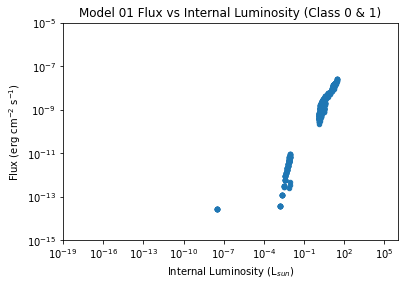

In [ ]:
# Define master lists to store data for master plots
lint_master, flux_master, lint_0_master, flux_0_master, lint_1_master, flux_1_master, lint_log_master, flux_log_master, lint_0_log_master, flux_0_log_master, lint_1_log_master, flux_1_log_master = [], [], [], [], [], [], [], [], [], [], [], []
# Open csv file to record linear coefficients
with open('linear_coefficients.csv', 'w') as f1, open('correlation_coefficient.csv', 'w') as f2:
  # Add headers
  f1.write('Model, Class, Wavelength, Slope, Uncertainty of slope, Intercept, Uncertainty of intercept\n')
  f2.write('Model, Class, Wavelength, Correlation coefficient (linear), Correlation coefficient (logged)\n')
  # Loop over every model
  for i, j in enumerate(tqdm(model_num_list)):
    # Split out appropriate internal luminosity and flux data
    if i == 0:
      lint, flux = lint_temp[:model[i]], flux_temp[:model[i]]
    else:
      lint, flux = lint_temp[model[i - 1]:model[i]], flux_temp[model[i - 1]:model[i]]
    # Split data into class 0 and 1
    lint_0, flux_0, lint_1, flux_1 = lint[:index[i]], flux[:index[i]], lint[index[i]:], flux[index[i]:]
    # Make an ordered tuples of (internal luminosity, flux), and sort them in ascending order by the luminosity values
    my_tuple, my_tuple_0, my_tuple_1 = list(sorted(zip(lint, flux))), list(sorted(zip(lint_0, flux_0))), list(sorted(zip(lint_1, flux_1)))
    # Remove missing values
    new_tuple, new_tuple_0, new_tuple_1 = [_ for _ in my_tuple if math.isnan(_[0]) == False], [_ for _ in my_tuple_0 if math.isnan(_[0]) == False], [_ for _ in my_tuple_1 if math.isnan(_[0]) == False]
    # Partition them into separate lists
    lint, flux, lint_0, flux_0, lint_1, flux_1 = [_[0] for _ in new_tuple], [_[1] for _ in new_tuple], [_[0] for _ in new_tuple_0], [_[1] for _ in new_tuple_0], [_[0] for _ in new_tuple_1], [_[1] for _ in new_tuple_1]
    # Take the log (base 10) of each
    lint_log, flux_log, lint_0_log, flux_0_log, lint_1_log, flux_1_log = np.log10(lint).tolist(), np.log10(flux).tolist(), np.log10(lint_0).tolist(), np.log10(flux_0).tolist(), np.log10(lint_1).tolist(), np.log10(flux_1).tolist()
    # Add data to master lists
    lint_master.extend(lint)
    flux_master.extend(flux)
    lint_0_master.extend(lint_0)
    flux_0_master.extend(flux_0)
    lint_1_master.extend(lint_1)
    flux_1_master.extend(flux_1)
    lint_log_master.extend(lint_log)
    flux_log_master.extend(flux_log)
    lint_0_log_master.extend(lint_0_log)
    flux_0_log_master.extend(flux_0_log)
    lint_1_log_master.extend(lint_1_log)
    flux_1_log_master.extend(flux_1_log)
    # Make flux vs internal luminosity plots, starting with Class 0 & 1
    plt.scatter(lint, flux, s=20)
    plt.title(f'Model {j} Flux vs Internal Luminosity (Class 0 & 1)')
    plt.xlabel('Internal Luminosity (L$_{sun}$)')
    plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-19, 1e6)
    plt.ylim(1e-15, 1e-5)
    # Find index where internal luminosity values >= 0.1
    for x, y in enumerate(lint):
      if y >= 0.1:   
        split = x
        break
    # Split the logged data such that internal luminosity values < 0.1 are rejected
    lint_log, flux_log = lint_log[split:], flux_log[split:]
    # Include constant in OLS models (which is not done by default)
    flux_log = sm.add_constant(flux_log)
    # Fit linear regression model to logged data 
    regression = sm.OLS(lint_log, flux_log)
    results = regression.fit()
    # Record linear coefficients and standard errors
    m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
    f1.write(f'{j}, 0 & 1, {wavelength}, {m}, {unc_m}, {b}, {unc_b}\n')
    # Compute correlation coefficient
    lin_corr, _ = pearsonr(lint, flux)
    log_corr, _ = pearsonr(lint_log, flux_log)
    f2.write(f'{j}, 0 & 1, {wavelength}, {lin_corr}, {log_corr}\n')
    # Visualize the linear regression
    L = [1e-15, 1e-5]
    F = 10**b * L**m
    plt.plot(F, L, color='b')
    plt.legend([f'Linear regression: $y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$'])
    # Save & clear plot
    plt.savefig(f'Figures/model_{j}_flux_vs_lint.eps')
    plt.clf()
    # Next, for Class 0
    plt.scatter(lint_0, flux_0, s=20)
    plt.title(f'Model {j} Flux vs Internal Luminosity (Class 0)')
    plt.xlabel('Internal Luminosity (L$_{sun}$)')
    plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-19, 1e6)
    plt.ylim(1e-15, 1e-5)
    # Find index where internal luminosity values >= 0.1
    for x, y in enumerate(lint_0):
      if y >= 0.1:   
        split = x
        break
    # Split the logged data such that internal luminosity values < 0.1 are rejected
    lint_0_log, flux_0_log = lint_0_log[split:], flux_0_log[split:]
    # Include constant in OLS models (which is not done by default)
    flux_0_log = sm.add_constant(flux_0_log)
    # Fit linear regression model to logged data 
    regression = sm.OLS(lint_0_log, flux_0_log)
    results = regression.fit()
    # Record linear coefficients and standard errors
    m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
    f1.write(f'{j}, 0, {wavelength}, {m}, {unc_m}, {b}, {unc_b}\n')
    # Compute correlation coefficient
    lin_corr, _ = pearsonr(lint_0, flux_0)
    log_corr, _ = pearsonr(lint_0_log, flux_0_log)
    f2.write(f'{j}, 0, {wavelength}, {lin_corr}, {log_corr}\n')
    # Visualize the linear regression
    L = [1e-15, 1e-5]
    F = 10**b * L**m
    plt.plot(F, L, color='b')
    plt.legend([f'Linear regression: $y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$'])
    # Save & clear plot
    plt.savefig(f'Figures/model_{j}_flux_vs_lint_class0.eps')
    plt.clf()
    # Finally, for class 1
    plt.scatter(lint_1, flux_1, s=20)
    plt.title(f'Model {j} Flux vs Internal Luminosity (Class 1)')
    plt.xlabel('Internal Luminosity (L$_{sun}$)')
    plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-19, 1e6)
    plt.ylim(1e-15, 1e-5)
    # Find index where internal luminosity values >= 0.1
    for x, y in enumerate(lint_1):
      if y >= 0.1:   
        split = x
        break
    # Split the logged data such that internal luminosity values < 0.1 are rejected
    lint_1_log, flux_1_log = lint_1_log[split:], flux_1_log[split:]
    # Include constant in OLS models (which is not done by default)
    flux_1_log = sm.add_constant(flux_1_log)
    # Fit linear regression model to logged data 
    regression = sm.OLS(lint_1_log, flux_1_log)
    results = regression.fit()
    # Record linear coefficients and standard errors
    m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
    f1.write(f'{j}, 1, {wavelength}, {m}, {unc_m}, {b}, {unc_b}\n')
    # Compute correlation coefficient
    lin_corr, _ = pearsonr(lint_1, flux_1)
    log_corr, _ = pearsonr(lint_1_log, flux_1_log)
    f2.write(f'{j}, 1, {wavelength}, {lin_corr}, {log_corr}\n')
    # Visualize the linear regression
    L = [1e-15, 1e-5]
    F = 10**b * L**m
    plt.plot(F, L, color='b')
    plt.legend([f'Linear regression: $y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$'])
    # Save & clear plot
    plt.savefig(f'Figures/model_{j}_flux_vs_lint_class1.eps')
    plt.clf()
f1.close()
f2.close()

Finally, make 3 master plots (Class 0, Class 1, and Class 0 & 1) containing all the data from every model, again fitting a linear regression to each, and recording the linear coefficients, standard errors, and correlation coefficients to a separate file.

In [ ]:
# Open csv file to record linear coefficients
with open('linear_regression.csv', 'a') as f1, open('correlation_coefficient.csv', 'a') as f2:
  # Class 0 & 1
  plt.scatter(lint_master, flux_master, s=20)
  plt.title('All Models Flux vs Internal Luminosity (Class 0 & 1)')
  plt.xlabel('Internal Luminosity (L$_{sun}$)')
  plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
  plt.xscale('log')
  plt.yscale('log')
  plt.xlim(1e-19, 1e6)
  plt.ylim(1e-15, 1e-5)
  # Find index where internal luminosity values >= 0.1
  for x, y in enumerate(lint_master):
    if y >= 0.1:   
      split = x
      break
  # Split the logged data such that internal luminosity values < 0.1 are rejected
  lint_log_master, flux_log_master = lint_log_master[split:], flux_log_master[split:]
  # Include constant in OLS models (which is not done by default)
  flux_log_master = sm.add_constant(flux_log_master)
  # Fit linear regression model to logged data 
  regression = sm.OLS(lint_log_master, flux_log_master)
  results = regression.fit()
  # Record linear coefficients and standard errors
  m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
  f1.write(f'All, 0 & 1, {wavelength}, {m}, {unc_m}, {b}, {unc_b}\n')
  # Compute correlation coefficient
  lin_corr, _ = pearsonr(lint_master, flux_master)
  log_corr, _ = pearsonr(lint_log_master, flux_log_master)
  f2.write(f'All, 0 & 1, {wavelength}, {lin_corr}, {log_corr}\n')
  # Visualize the linear regression
  L = [1e-15, 1e-5]
  F = 10**b * L**m
  plt.plot(F, L, color='b')
  plt.legend([f'Linear regression: $y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$'])
  # Save & clear plot
  plt.savefig('Figures/master_flux_vs_lint.eps')
  plt.clf()
  # Class 0 
  plt.scatter(lint_0_master, flux_0_master, s=20)
  plt.title('All Models Flux vs Internal Luminosity (Class 0)')
  plt.xlabel('Internal Luminosity (L$_{sun}$)')
  plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
  plt.xscale('log')
  plt.yscale('log')
  plt.xlim(1e-19, 1e6)
  plt.ylim(1e-15, 1e-5)
  # Find index where internal luminosity values >= 0.1
  for x, y in enumerate(lint_0_master):
    if y >= 0.1:   
      split = x
      break
  # Split the logged data such that internal luminosity values < 0.1 are rejected
  lint_0_log_master, flux_0_log_master = lint_0_log_master[split:], flux_0_log_master[split:]
  # Include constant in OLS models (which is not done by default)
  flux_0_log_master = sm.add_constant(flux_0_log_master)
  # Fit linear regression model to logged data 
  regression = sm.OLS(lint_0_log_master, flux_0_log_master)
  results = regression.fit()
  # Record linear coefficients and standard errors
  m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
  f1.write(f'All, 0, {wavelength}, {m}, {unc_m}, {b}, {unc_b}\n')
  # Compute correlation coefficient
  lin_corr, _ = pearsonr(lint_0_master, flux_0_master)
  log_corr, _ = pearsonr(lint_0_log_master, flux_0_log_master)
  f2.write(f'All, 0, {wavelength}, {lin_corr}, {log_corr}\n')
  # Visualize the linear regression
  L = [1e-15, 1e-5]
  F = 10**b * L**m
  plt.plot(F, L, color='b')
  plt.legend([f'Linear regression: $y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$'])
  # Save & clear plot
  plt.savefig('Figures/master_flux_vs_lint_class0.eps')
  plt.clf()
  # Class 1
  plt.scatter(lint_1_master, flux_1_master, s=20)
  plt.title('All Models Flux vs Internal Luminosity (Class 1)')
  plt.xlabel('Internal Luminosity (L$_{sun}$)')
  plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
  plt.xscale('log')
  plt.yscale('log')
  plt.xlim(1e-19, 1e6)
  plt.ylim(1e-15, 1e-5)
  # Find index where internal luminosity values >= 0.1
  for x, y in enumerate(lint_1_master):
    if y >= 0.1:   
      split = x
      break
  # Split the logged data such that internal luminosity values < 0.1 are rejected
  lint_1_log_master, flux_1_log_master = lint_1_log_master[split:], flux_1_log_master[split:]
  # Include constant in OLS models (which is not done by default)
  flux_1_log_master = sm.add_constant(flux_1_log_master)
  # Fit linear regression model to logged data 
  regression = sm.OLS(lint_1_log_master, flux_1_log_master)
  results = regression.fit()
  # Record linear coefficients and standard errors
  m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
  f1.write(f'All, 1, {wavelength}, {m}, {unc_m}, {b}, {unc_b}\n')
  # Compute correlation coefficient
  lin_corr, _ = pearsonr(lint_1_master, flux_1_master)
  log_corr, _ = pearsonr(lint_1_log_master, flux_1_log_master)
  f2.write(f'All, 1, {wavelength}, {lin_corr}, {log_corr}\n')
  # Visualize the linear regression
  L = [1e-15, 1e-5]
  F = 10**b * L**m
  plt.plot(F, L, color='b')
  plt.legend([f'Linear regression: $y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$'])
  # Save & clear plot
  plt.savefig('Figures/master_flux_vs_lint_class1.eps')
  plt.clf()
f1.close()
f2.close()

# Conclusion

[total runtime, performance metrics, memory usage]

[summary of findings, link to paper]

---
---
---
# Temp: Fix `log_corr`